<a href="https://colab.research.google.com/github/cifkao/nopdb/blob/main/docs/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspecting deep neural networks with NoPdb

[NoPdb](https://github.com/cifkao/nopdb) is a **programmatic** (non-interactive) **debugger** for Python. This means it gives you access to **debugger-like superpowers** directly from your code.

This notebook shows how to use NoPdb to dissect a pre-trained [**Vision Transformer (ViT)**](https://arxiv.org/abs/2010.11929), allowing to **plot** and even **modify** its attention weights, which are normally not accessible from user code. We are going to use a pre-trained ViT from the [`timm`](https://github.com/rwightman/pytorch-image-models) package, which contains easy-to-use PyTorch implementations of many computer vision models.

## Install and import packages

In [ ]:
!pip install git+https://github.com/cifkao/nopdb
!pip install timm==0.4.5

In [4]:
import urllib

import IPython.display as ipd
import numpy as np
import PIL
import timm
from timm.data import resolve_data_config, create_transform
import torch

import nopdb

## Load the model

In [9]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.cuda()
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

## Download some data

In [ ]:
# Download an input image
!wget https://raw.githubusercontent.com/cifkao/nopdb/data/cows.jpg

In [ ]:
# Get imagenet class names
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

In [ ]:
# Get the function to transform the image to a tensor
config = resolve_data_config({}, model=model)
transform = create_transform(**config)


# Define some functions to map the tensor back to an image

def inv_normalize(tensor):
    """Normalize an image tensor back to the 0-255 range."""
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()) * (256 - 1e-5)
    return tensor

def inv_transform(tensor, normalize=True):
    """Convert a tensor to an image."""
    tensor = inv_normalize(tensor)
    array = tensor.detach().cpu().numpy()
    array = array.transpose(1, 2, 0).astype(np.uint8)
    return PIL.Image.fromarray(array)

## Run the model

In [23]:
def predict(input):
    """Run the model on an input and print the predicted classes with probabilities."""
    with torch.no_grad():
        [logits] = model(input[None])
        probs = torch.softmax(logits, dim=0)
        topk_prob, topk_id = torch.topk(probs, 5)
        for i in range(topk_prob.size(0)):
            print(classes[topk_id[i]], topk_prob[i].item(), sep="\t")

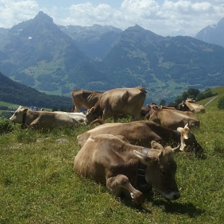

In [19]:
# Load and display our image
img = PIL.Image.open('cows.jpg').convert('RGB')
input = transform(img).cuda()
inv_transform(input)

In [25]:
predict(input)

alp	0.7936609983444214
ox	0.1110275536775589
valley	0.029854662716388702
oxcart	0.008171545341610909
ibex	0.008044715970754623


## Capture and plot the attention weights

Let's plot the attention weights inside the 3rd block. To do this, we capture the local variables inside the `forward` method of the `model.blocks[2].attn` layer:

In [72]:
# Here is where all the magic happens!
with nopdb.capture_call(model.blocks[2].attn.forward) as attn_call:
    predict(input)

alp	0.7936609983444214
ox	0.1110275536775589
valley	0.029854662716388702
oxcart	0.008171545341610909
ibex	0.008044715970754623


In [73]:
# Check the local variables that we captured
attn_call.locals.keys()

dict_keys(['self', 'x', 'B', 'N', 'C', 'qkv', 'q', 'k', 'v', 'attn'])

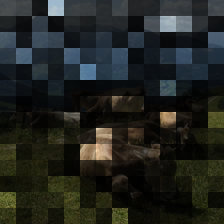

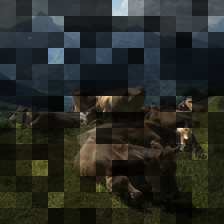

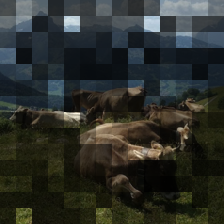

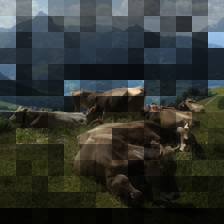

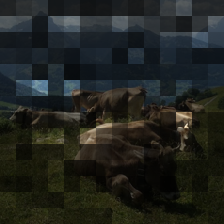

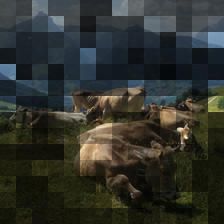

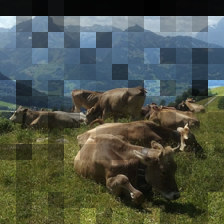

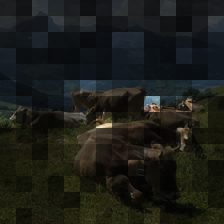

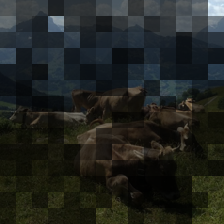

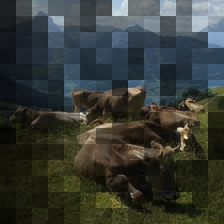

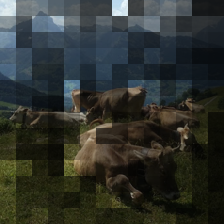

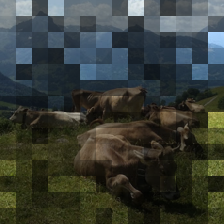

In [74]:
def plot_weights(input, weights):
    with torch.no_grad():
        # Loop over attention heads
        for h_weights in weights[0]:
            h_weights = h_weights.mean(axis=-2)  # Average over all attention keys
            h_weights = h_weights[1:]  # Skip the [CLS] token

            # Multiply each patch of the input image by the corresponding weight
            plot = inv_normalize(input.clone())
            for i in range(h_weights.shape[0]):
                x = i * 16 % 224
                y = i // (224 // 16) * 16
                plot[:, y:y + 16, x:x + 16] *= h_weights[i]
            ipd.display(inv_transform(plot, normalize=False))
    
plot_weights(input, attn_call.locals['attn'])

## Modify the weights
We will now run the model again, but multiply the attention logits (pre-softmax activations) in all layers by a constant and observe how this changes the predictions. We are also going to capture and plot the (modified) weights in the 3rd layer as before.

In [75]:
from timm.models.vision_transformer import Attention

with torch.no_grad():
    # Set a breakpoint on line 174 in the Attention module, just before the softmax
    with nopdb.breakpoint(function=Attention.forward, line=174) as bp, \
         nopdb.capture_call(model.blocks[2].attn.forward) as attn_call:
        bp.exec('attn = attn * 3')
        predict(input)

balloon	0.2919278144836426
alp	0.12356045097112656
valley	0.049701496958732605
parachute	0.03465363383293152
airship	0.01919153518974781


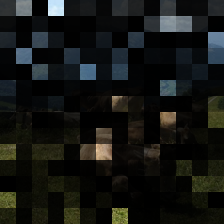

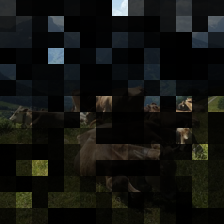

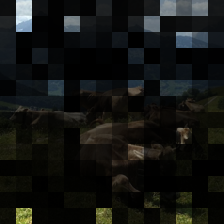

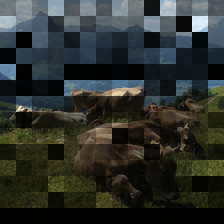

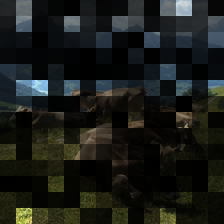

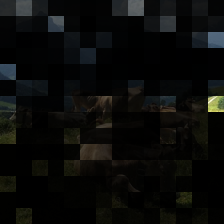

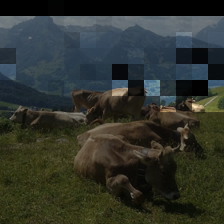

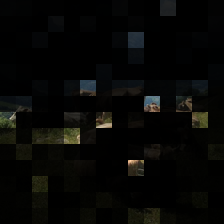

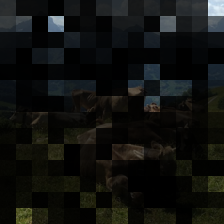

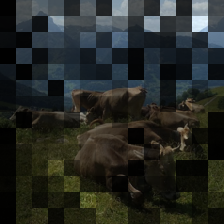

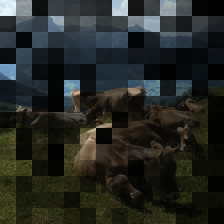

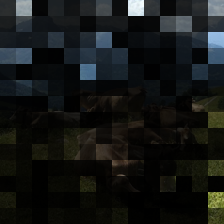

In [76]:
plot_weights(input, attn_call.locals['attn'])